In [1]:
import numpy as np
from math import factorial
import matplotlib.pyplot as plt

D_MAX = 8

In [2]:
class ClusterDataset:
    def __init__(self, n=400, d=8) -> None:
        self.n = n
        self.d = d
        self.s = (factorial(d) / factorial(D_MAX)) ** (1 / d)  # Side length of simplex

    def generate_hypercube_points(self, n, d):
        return np.random.uniform(0, 1, size=(n, d))

    def generate_simplex_points(self, n, d, s):
        points = np.random.dirichlet(np.ones(d), size=n)
        return points * s

    def generate(self):
        n_negative = 4 * self.n // 5
        n_positive_simplex = self.n // 10
        n_positive_remaining = self.n // 10

        negative_points = self.generate_hypercube_points(n_negative, self.d)

        positive_simplex_points = self.generate_simplex_points(
            n_positive_simplex, self.d, self.s
        )

        positive_remaining_points = self.generate_hypercube_points(
            n_positive_remaining, self.d
        )

        X = np.vstack(
            (negative_points, positive_simplex_points, positive_remaining_points)
        )
        

        y = np.hstack(
            (np.zeros(n_negative), np.ones(n_positive_simplex + n_positive_remaining))
        )

        return X, y


In [3]:
class TwoClusterDataset:
    def __init__(self, n=400, d=8) -> None:
        self.n = n
        self.d = d
        self.s = (factorial(d) / factorial(D_MAX)) ** (1 / d)  # Side length of simplex

    def generate_hypercube_points(self, n, d):
        return np.random.uniform(0, 1, size=(n, d))

    def generate_simplex_points(self, n, d, s):
        points = np.random.dirichlet(np.ones(d), size=n)
        return points * s

    def generate_diametrically_opposite(self, n, d, s):
        points = np.random.dirichlet(np.ones(d), size=n)
        points = points * s
        return np.ones(d) - points
        
    def generate(self):
        n_negative = 4 * self.n // 5
        n_positive_simplex = self.n // 20
        n_positive_simplex_opp = self.n // 20
        n_positive_remaining = self.n // 10

        negative_points = self.generate_hypercube_points(n_negative, self.d)

        positive_simplex_points = self.generate_simplex_points(
            n_positive_simplex, self.d, self.s
        )
        positive_simplex_points_opp = self.generate_diametrically_opposite(
            n_positive_simplex_opp, self.d, self.s
        )

        positive_remaining_points = self.generate_hypercube_points(
            n_positive_remaining, self.d
        )

        X = np.vstack(
            (negative_points, positive_simplex_points, positive_simplex_points_opp, positive_remaining_points)
        )
        

        y = np.hstack(
            (np.zeros(n_negative), np.ones(n_positive_simplex + n_positive_simplex_opp + n_positive_remaining))
        )

        return X, y

In [4]:
class DiffusedBenchmark:
    def __init__(self, n=400, d=8) -> None:
        self.n = n
        self.d = d

    def generate_hypercube_points(self, n, d):
        return np.random.uniform(0, 1, size=(n, d))

    def generate(self):
        n_negative = self.n // 2
        n_positive = self.n // 2
        
        negative_points = self.generate_hypercube_points(n_negative, self.d)
        positive_points = self.generate_hypercube_points(n_positive, self.d)

        X = np.vstack(
            (negative_points, positive_points)
        )
        

        y = np.hstack(
            (np.zeros(n_negative), np.ones(n_positive))
        )

        return X, y

In [5]:
def plot(X, y):
    plt.figure(figsize=(4, 4))
    plt.scatter(
        X[y == 0][:, 0],
        X[y == 0][:, 1],
        color="blue",
        label="Negative Samples",
        alpha=0.5,
        marker='x'
    )
    plt.scatter(
        X[y == 1][:, 0],
        X[y == 1][:, 1],
        color="red",
        label="Positive Samples",
        alpha=0.5,
        marker='x',
    )
    plt.title("Cluster Benchmark Dataset (d=2)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
cd = ClusterDataset(400, 4)

In [7]:
X, y = cd.generate()

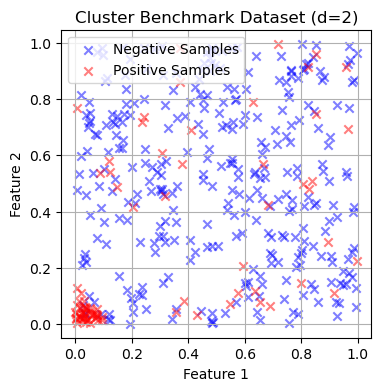

In [8]:
plot(X, y)

In [9]:
(factorial(2) / factorial(8)) ** (1/2)

0.0070429521227376385

In [10]:
tcd = TwoClusterDataset(400, 4)

In [11]:
X_t, y_t = tcd.generate()

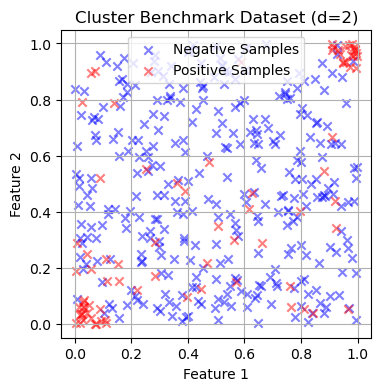

In [12]:
plot(X_t, y_t)

In [13]:
df = DiffusedBenchmark(400, 2)

In [14]:
X_df, y_df = df.generate()

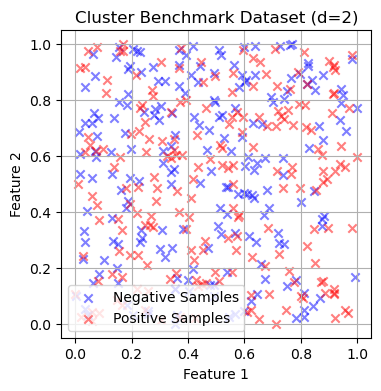

In [15]:
plot(X_df, y_df)